In [1]:
!pip install tensorflow tensorflow-datasets matplotlib scikit-learn


In [7]:
import numpy as np
from PIL import Image, ImageDraw

def strokes_to_image(strokes, size=28, stroke_width=4):
    """
    Converte strokes (lista de coordenadas do QuickDraw) para bitmap 28x28.
    """
    img = Image.new("L", (256, 256), color=0)
    draw = ImageDraw.Draw(img)

    # Desenhar cada traço
    for stroke in strokes:
        xs, ys = stroke
        points = list(zip(xs, ys))
        draw.line(points, fill=255, width=stroke_width)

    # Redimensionar para 28x28 usando resampling moderno
    img = img.resize((size, size), Image.Resampling.LANCZOS)
    return np.array(img)


In [10]:
all_images = []
all_labels = []

for idx, cls in enumerate(CLASSES):
    print("Processando", cls, "...")
    imgs = download_class(cls)
    all_images.append(imgs)
    all_labels.append(np.full((len(imgs),), idx))

# Juntar tudo
X = np.concatenate(all_images, axis=0)
y = np.concatenate(all_labels, axis=0)


Processando cat ...
Processando dog ...
Processando face ...
Processando tree ...
Processando airplane ...
Processando car ...
Processando chair ...
Processando apple ...
Processando fish ...
Processando bird ...


In [11]:
for idx, cls in enumerate(CLASSES):
    print("Processando", cls, "...")
    imgs = download_class(cls)
    all_images.append(imgs)
    all_labels.append(np.full((len(imgs),), idx))


Processando cat ...
Processando dog ...
Processando face ...
Processando tree ...
Processando airplane ...
Processando car ...
Processando chair ...
Processando apple ...
Processando fish ...
Processando bird ...


In [12]:
print("Shape final de X:", X.shape)
print("Shape final de y:", y.shape)
print("Classes distintas:", np.unique(y))


Shape final de X: (5000, 28, 28)
Shape final de y: (5000,)
Classes distintas: [0 1 2 3 4 5 6 7 8 9]


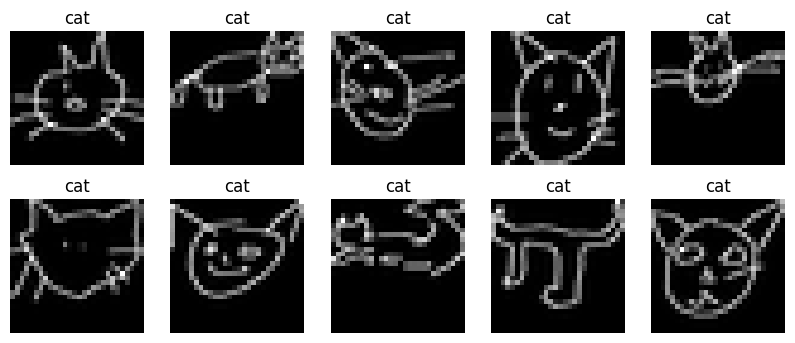

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X[i].reshape(28,28), cmap="gray")
    plt.title(CLASSES[y[i]])
    plt.axis("off")
plt.show()


In [14]:
from sklearn.model_selection import train_test_split

# Normalizar X se ainda não fez
X = X.astype("float32") / 255.0
X = X.reshape(-1, 28, 28, 1)

# 80% treino, 10% val, 10% teste
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Treino:", X_train.shape)
print("Validação:", X_val.shape)
print("Teste:", X_test.shape)


Treino: (4000, 28, 28, 1)
Validação: (500, 28, 28, 1)
Teste: (500, 28, 28, 1)


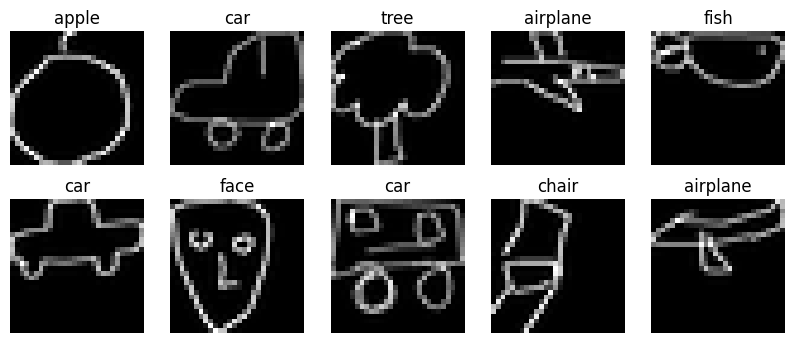

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap="gray")
    plt.title(CLASSES[y_train[i]])
    plt.axis("off")
plt.show()


In [ ]:
#0) Instalação + imports (executar primeiro)

In [16]:
# Só se ainda não tiver instalado
!pip install -q tensorflow scikit-learn matplotlib

import os
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import itertools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
#1) Função utilitária: fixar semente para reprodutibilidade (usaremos 3 seeds)

In [17]:
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

SEEDS = [42, 123, 999]  # três execuções para média ± desvio


In [18]:
#2) (Se você já tem X_train, X_val, X_test, y_train, y_val, y_test no ambiente — pular)

In [19]:
print("Treino:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Teste:", X_test.shape, y_test.shape)
NUM_CLASSES = len(np.unique(y_train))
print("Num classes:", NUM_CLASSES)


Treino: (4000, 28, 28, 1) (4000,)
Val: (500, 28, 28, 1) (500,)
Teste: (500, 28, 28, 1) (500,)
Num classes: 10


In [20]:
#3) Construção do MLP (baixo número de parâmetros — < 1M)

In [21]:
def build_mlp(input_shape=(28,28,1), num_classes=10, l2=1e-4, dropout_rate=0.3):
    inputs = keras.Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    x = layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(l2))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(l2))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(l2))(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="mlp_baseline")
    return model

# Quick check
model = build_mlp(input_shape=X_train.shape[1:], num_classes=NUM_CLASSES)
model.summary()


Model: "mlp_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#4) Callbacks e compile

In [22]:
def compile_model(model, lr=1e-3):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def get_callbacks(run_id):
    return [
        EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
        ModelCheckpoint(f"mlp_run_{run_id}.h5", save_best_only=True, monitor="val_loss", verbose=1)
    ]


In [23]:
#5) Treino — função que faz 1 run e retorna histórico + métricas

In [24]:
def train_one_run(seed, run_id, epochs=50, batch_size=64):
    print(f"\n=== RUN {run_id} - seed {seed} ===")
    set_seed(seed)
    model = build_mlp(input_shape=X_train.shape[1:], num_classes=NUM_CLASSES)
    compile_model(model)
    callbacks = get_callbacks(run_id)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=2
    )

    # carregar melhor peso salvo
    model.load_weights(f"mlp_run_{run_id}.h5")

    # Avaliação no conjunto de teste
    test_preds = np.argmax(model.predict(X_test), axis=1)
    acc = np.mean(test_preds == y_test)
    f1 = f1_score(y_test, test_preds, average="macro")

    print(f"Test acc: {acc:.4f}   F1-macro: {f1:.4f}")

    return {"model": model, "history": history, "test_acc": acc, "test_f1": f1, "y_pred": test_preds}


In [25]:
#6) Rodar 3 execuções e guardar resultados (leva poucos minutos)

In [26]:
results = []
for i, s in enumerate(SEEDS):
    res = train_one_run(seed=s, run_id=i, epochs=50, batch_size=64)
    results.append(res)



=== RUN 0 - seed 42 ===
Epoch 1/50

Epoch 1: val_loss improved from inf to 1.40101, saving model to mlp_run_0.h5


63/63 - 16s - 261ms/step - accuracy: 0.3750 - loss: 1.9382 - val_accuracy: 0.5780 - val_loss: 1.4010 - learning_rate: 1.0000e-03
Epoch 2/50

Epoch 2: val_loss improved from 1.40101 to 1.25407, saving model to mlp_run_0.h5


63/63 - 2s - 32ms/step - accuracy: 0.5955 - loss: 1.3272 - val_accuracy: 0.6420 - val_loss: 1.2541 - learning_rate: 1.0000e-03
Epoch 3/50

Epoch 3: val_loss improved from 1.25407 to 1.18521, saving model to mlp_run_0.h5


63/63 - 1s - 21ms/step - accuracy: 0.6765 - loss: 1.0829 - val_accuracy: 0.6840 - val_loss: 1.1852 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: val_loss did not improve from 1.18521
63/63 - 2s - 35ms/step - accuracy: 0.7483 - loss: 0.9197 - val_accuracy: 0.6780 - val_loss: 1.1933 - learning_rate: 1.0000e-03
Epoch 5/50

Epoch 5: val_loss improved from 1.18521 to 1.17368, saving model to mlp_run_0.h5


63/63 - 1s - 22ms/step - accuracy: 0.7947 - loss: 0.7711 - val_accuracy: 0.6940 - val_loss: 1.1737 - learning_rate: 1.0000e-03
Epoch 6/50

Epoch 6: val_loss did not improve from 1.17368
63/63 - 3s - 42ms/step - accuracy: 0.8460 - loss: 0.6280 - val_accuracy: 0.6980 - val_loss: 1.2315 - learning_rate: 1.0000e-03
Epoch 7/50

Epoch 7: val_loss did not improve from 1.17368
63/63 - 1s - 14ms/step - accuracy: 0.8795 - loss: 0.5322 - val_accuracy: 0.6820 - val_loss: 1.2332 - learning_rate: 1.0000e-03
Epoch 8/50

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: val_loss did not improve from 1.17368
63/63 - 1s - 21ms/step - accuracy: 0.9115 - loss: 0.4300 - val_accuracy: 0.6920 - val_loss: 1.3063 - learning_rate: 1.0000e-03
Epoch 9/50

Epoch 9: val_loss did not improve from 1.17368
63/63 - 1s - 23ms/step - accuracy: 0.9425 - loss: 0.3385 - val_accuracy: 0.6920 - val_loss: 1.3394 - learning_rate: 5.0000e-04
Epoch 10/50

Epoch 10: val_loss did not improve from

63/63 - 3s - 50ms/step - accuracy: 0.3715 - loss: 1.9418 - val_accuracy: 0.5860 - val_loss: 1.4077 - learning_rate: 1.0000e-03
Epoch 2/50

Epoch 2: val_loss improved from 1.40767 to 1.25505, saving model to mlp_run_1.h5


63/63 - 1s - 17ms/step - accuracy: 0.6053 - loss: 1.3276 - val_accuracy: 0.6360 - val_loss: 1.2551 - learning_rate: 1.0000e-03
Epoch 3/50

Epoch 3: val_loss improved from 1.25505 to 1.21221, saving model to mlp_run_1.h5


63/63 - 1s - 14ms/step - accuracy: 0.6835 - loss: 1.0710 - val_accuracy: 0.6640 - val_loss: 1.2122 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: val_loss improved from 1.21221 to 1.17359, saving model to mlp_run_1.h5


63/63 - 1s - 17ms/step - accuracy: 0.7435 - loss: 0.9028 - val_accuracy: 0.6860 - val_loss: 1.1736 - learning_rate: 1.0000e-03
Epoch 5/50

Epoch 5: val_loss did not improve from 1.17359
63/63 - 1s - 21ms/step - accuracy: 0.8048 - loss: 0.7423 - val_accuracy: 0.7000 - val_loss: 1.1906 - learning_rate: 1.0000e-03
Epoch 6/50

Epoch 6: val_loss did not improve from 1.17359
63/63 - 3s - 49ms/step - accuracy: 0.8450 - loss: 0.6237 - val_accuracy: 0.6800 - val_loss: 1.2545 - learning_rate: 1.0000e-03
Epoch 7/50

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 7: val_loss did not improve from 1.17359
63/63 - 2s - 26ms/step - accuracy: 0.8885 - loss: 0.4937 - val_accuracy: 0.6860 - val_loss: 1.3558 - learning_rate: 1.0000e-03
Epoch 8/50

Epoch 8: val_loss did not improve from 1.17359
63/63 - 1s - 18ms/step - accuracy: 0.9310 - loss: 0.3780 - val_accuracy: 0.6800 - val_loss: 1.3448 - learning_rate: 5.0000e-04
Epoch 9/50

Epoch 9: val_loss did not improve from 1

63/63 - 7s - 105ms/step - accuracy: 0.3635 - loss: 1.9554 - val_accuracy: 0.6060 - val_loss: 1.4080 - learning_rate: 1.0000e-03
Epoch 2/50

Epoch 2: val_loss improved from 1.40799 to 1.27816, saving model to mlp_run_2.h5


63/63 - 4s - 61ms/step - accuracy: 0.6162 - loss: 1.3058 - val_accuracy: 0.6240 - val_loss: 1.2782 - learning_rate: 1.0000e-03
Epoch 3/50

Epoch 3: val_loss improved from 1.27816 to 1.24179, saving model to mlp_run_2.h5


63/63 - 2s - 34ms/step - accuracy: 0.6708 - loss: 1.1053 - val_accuracy: 0.6540 - val_loss: 1.2418 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: val_loss did not improve from 1.24179
63/63 - 2s - 30ms/step - accuracy: 0.7347 - loss: 0.9295 - val_accuracy: 0.6500 - val_loss: 1.2605 - learning_rate: 1.0000e-03
Epoch 5/50

Epoch 5: val_loss did not improve from 1.24179
63/63 - 2s - 32ms/step - accuracy: 0.7915 - loss: 0.7735 - val_accuracy: 0.6600 - val_loss: 1.2817 - learning_rate: 1.0000e-03
Epoch 6/50

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 6: val_loss did not improve from 1.24179
63/63 - 2s - 27ms/step - accuracy: 0.8475 - loss: 0.6203 - val_accuracy: 0.6700 - val_loss: 1.3086 - learning_rate: 1.0000e-03
Epoch 7/50

Epoch 7: val_loss did not improve from 1.24179
63/63 - 3s - 53ms/step - accuracy: 0.8855 - loss: 0.4941 - val_accuracy: 0.6920 - val_loss: 1.2497 - learning_rate: 5.0000e-04
Epoch 8/50

Epoch 8: val_loss did not improve from 1

In [ ]:
#7) Agregar resultados: média ± desvio (exigir pelo enunciado)

In [27]:
accs = [r["test_acc"] for r in results]
f1s = [r["test_f1"] for r in results]

print("Accuracy (mean ± std): {:.4f} ± {:.4f}".format(np.mean(accs), np.std(accs)))
print("F1-macro (mean ± std): {:.4f} ± {:.4f}".format(np.mean(f1s), np.std(f1s)))


Accuracy (mean ± std): 0.7120 ± 0.0085
F1-macro (mean ± std): 0.7011 ± 0.0074


In [ ]:
#8) Plots — curvas de perda e acurácia (pegaremos a melhor run por val_loss ou só plotamos as 3)

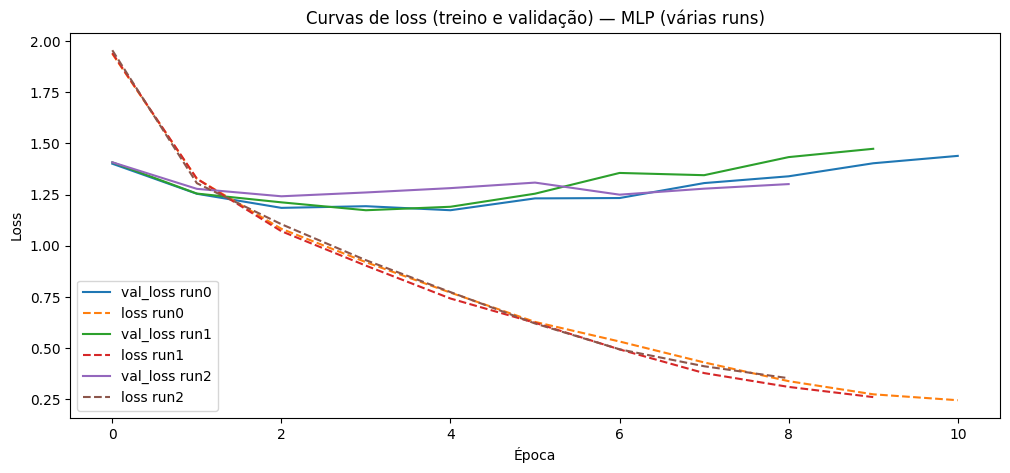

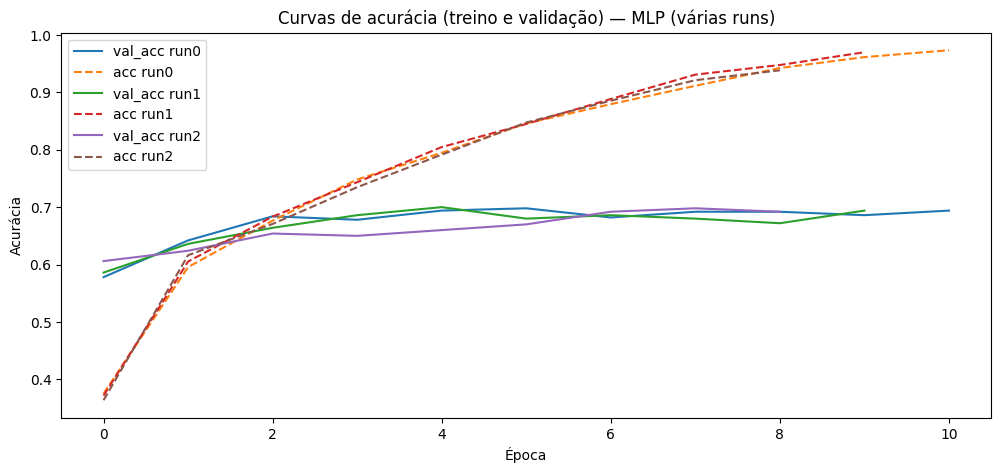

In [28]:
# Plot das curvas de treino/val para cada run
plt.figure(figsize=(12,5))
for i, r in enumerate(results):
    h = r["history"].history
    plt.plot(h["val_loss"], label=f"val_loss run{i}")
    plt.plot(h["loss"], linestyle="--", label=f"loss run{i}")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Curvas de loss (treino e validação) — MLP (várias runs)")
plt.legend()
plt.show()

# Acurácia
plt.figure(figsize=(12,5))
for i, r in enumerate(results):
    h = r["history"].history
    plt.plot(h["val_accuracy"], label=f"val_acc run{i}")
    plt.plot(h["accuracy"], linestyle="--", label=f"acc run{i}")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.title("Curvas de acurácia (treino e validação) — MLP (várias runs)")
plt.legend()
plt.show()


In [ ]:
#9) Matriz de confusão (usar a run com melhor val_loss / ou primeira run)

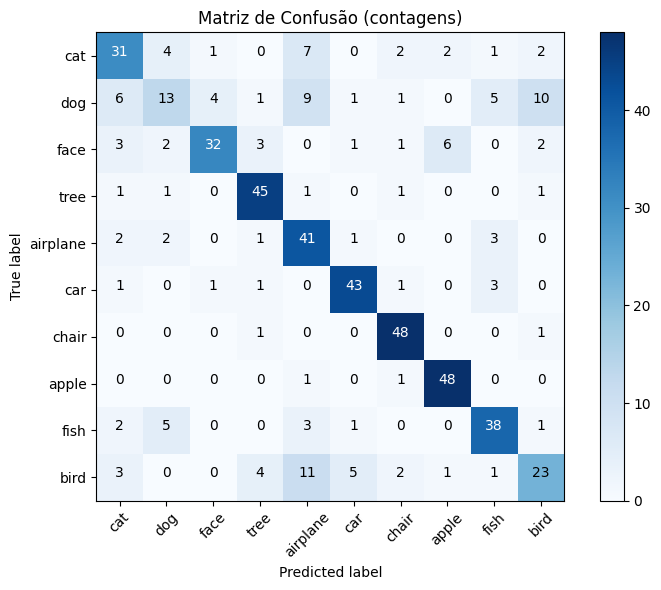

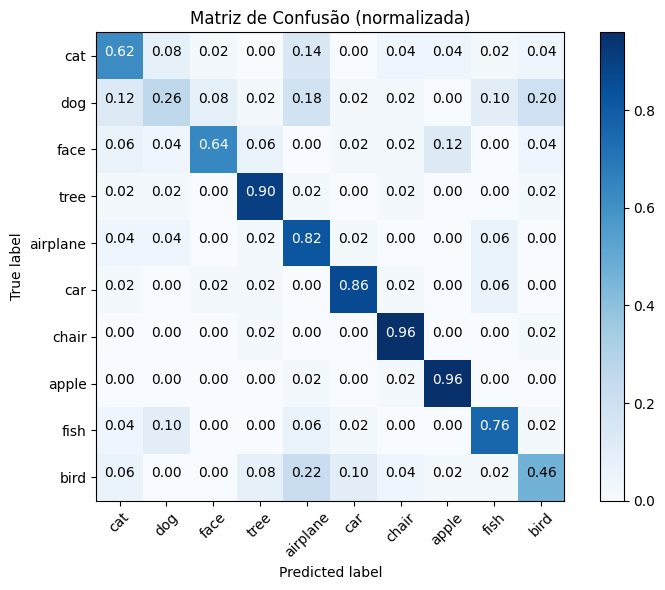

In [29]:
# Escolher run com maior F1 ou menor val_loss (aqui escolhemos a que teve maior F1)
best_idx = np.argmax([r["test_f1"] for r in results])
best_preds = results[best_idx]["y_pred"]

cm = confusion_matrix(y_test, best_preds)

def plot_confusion_matrix(cm, classes, normalize=False, title="Matriz de Confusão", cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(cm, CLASSES, normalize=False, title="Matriz de Confusão (contagens)")
plot_confusion_matrix(cm, CLASSES, normalize=True, title="Matriz de Confusão (normalizada)")


In [ ]:
#10) Relatório rápido dos resultados e classification report

In [30]:
print("Best run index:", best_idx)
print("Classification report (best run):")
print(classification_report(y_test, best_preds, target_names=CLASSES, digits=4))


Best run index: 1
Classification report (best run):
              precision    recall  f1-score   support

         cat     0.6327    0.6200    0.6263        50
         dog     0.4815    0.2600    0.3377        50
        face     0.8421    0.6400    0.7273        50
        tree     0.8036    0.9000    0.8491        50
    airplane     0.5616    0.8200    0.6667        50
         car     0.8269    0.8600    0.8431        50
       chair     0.8421    0.9600    0.8972        50
       apple     0.8421    0.9600    0.8972        50
        fish     0.7451    0.7600    0.7525        50
        bird     0.5750    0.4600    0.5111        50

    accuracy                         0.7240       500
   macro avg     0.7153    0.7240    0.7108       500
weighted avg     0.7153    0.7240    0.7108       500



##CNN


In [31]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import itertools


In [ ]:
#Função seed

In [32]:
def set_seed(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

SEEDS = [42, 123, 999]


In [ ]:
#Arquitetura da CNN intermediária

In [33]:
def build_cnn(input_shape=(28,28,1), num_classes=10, l2=1e-4, dropout_rate=0.3):
    inputs = keras.Input(shape=input_shape)

    # Bloco 1
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same",
                      kernel_regularizer=keras.regularizers.l2(l2))(inputs)
    x = layers.MaxPooling2D((2,2))(x)

    # Bloco 2
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same",
                      kernel_regularizer=keras.regularizers.l2(l2))(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Bloco 3
    x = layers.Conv2D(128, (3,3), activation="relu", padding="same",
                      kernel_regularizer=keras.regularizers.l2(l2))(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Flatten + Dense
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(l2))(x)
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="cnn_intermediaria")
    return model

# Ver parâmetros
model = build_cnn(input_shape=X_train.shape[1:], num_classes=len(np.unique(y_train)))
model.summary()


Model: "cnn_intermediaria"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,410 (1.49 MB)

 Trainable params: 390,410 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#3) Compile + callbacks

In [34]:
def compile_model(model, lr=1e-3):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def get_callbacks(run_id):
    return [
        EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
        ModelCheckpoint(f"cnn_run_{run_id}.h5", save_best_only=True, monitor="val_loss")
    ]


In [ ]:
#Treinar 1 run

In [35]:
def train_one_cnn_run(seed, run_id, epochs=50, batch_size=64):
    print(f"\n=== CNN RUN {run_id} (seed {seed}) ===")
    set_seed(seed)

    model = build_cnn(input_shape=X_train.shape[1:], num_classes=len(np.unique(y_train)))
    compile_model(model)

    callbacks = get_callbacks(run_id)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=2
    )

    # carregar melhor versão
    model.load_weights(f"cnn_run_{run_id}.h5")

    preds = np.argmax(model.predict(X_test), axis=1)
    acc = np.mean(preds == y_test)
    f1 = f1_score(y_test, preds, average="macro")

    print(f"Test ACC: {acc:.4f}  |  F1-macro: {f1:.4f}")

    return {"model": model, "history": history, "preds": preds, "acc": acc, "f1": f1}


In [ ]:
#Rodar as 3 execuções

In [36]:
cnn_results = []

for i, seed in enumerate(SEEDS):
    r = train_one_cnn_run(seed, i, epochs=50, batch_size=64)
    cnn_results.append(r)



=== CNN RUN 0 (seed 42) ===
Epoch 1/50


63/63 - 12s - 192ms/step - accuracy: 0.4202 - loss: 1.7348 - val_accuracy: 0.6220 - val_loss: 1.2131 - learning_rate: 1.0000e-03
Epoch 2/50


63/63 - 9s - 140ms/step - accuracy: 0.6687 - loss: 1.0809 - val_accuracy: 0.6900 - val_loss: 0.9468 - learning_rate: 1.0000e-03
Epoch 3/50


63/63 - 10s - 165ms/step - accuracy: 0.7440 - loss: 0.8323 - val_accuracy: 0.7640 - val_loss: 0.8361 - learning_rate: 1.0000e-03
Epoch 4/50


63/63 - 11s - 170ms/step - accuracy: 0.7847 - loss: 0.7061 - val_accuracy: 0.7680 - val_loss: 0.7767 - learning_rate: 1.0000e-03
Epoch 5/50


63/63 - 19s - 309ms/step - accuracy: 0.8238 - loss: 0.5960 - val_accuracy: 0.8020 - val_loss: 0.7302 - learning_rate: 1.0000e-03
Epoch 6/50
63/63 - 7s - 112ms/step - accuracy: 0.8435 - loss: 0.5328 - val_accuracy: 0.7940 - val_loss: 0.7586 - learning_rate: 1.0000e-03
Epoch 7/50
63/63 - 6s - 88ms/step - accuracy: 0.8662 - loss: 0.4586 - val_accuracy: 0.7960 - val_loss: 0.7577 - learning_rate: 1.0000e-03
Epoch 8/50


63/63 - 11s - 168ms/step - accuracy: 0.8848 - loss: 0.4126 - val_accuracy: 0.8100 - val_loss: 0.7269 - learning_rate: 1.0000e-03
Epoch 9/50
63/63 - 6s - 98ms/step - accuracy: 0.8967 - loss: 0.3672 - val_accuracy: 0.8100 - val_loss: 0.7475 - learning_rate: 1.0000e-03
Epoch 10/50
63/63 - 10s - 154ms/step - accuracy: 0.9147 - loss: 0.3199 - val_accuracy: 0.8140 - val_loss: 0.7619 - learning_rate: 1.0000e-03
Epoch 11/50

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
63/63 - 10s - 161ms/step - accuracy: 0.9210 - loss: 0.2936 - val_accuracy: 0.7960 - val_loss: 0.7948 - learning_rate: 1.0000e-03
Epoch 12/50
63/63 - 7s - 116ms/step - accuracy: 0.9400 - loss: 0.2446 - val_accuracy: 0.8020 - val_loss: 0.8142 - learning_rate: 5.0000e-04
Epoch 13/50
63/63 - 6s - 91ms/step - accuracy: 0.9555 - loss: 0.2085 - val_accuracy: 0.8100 - val_loss: 0.8710 - learning_rate: 5.0000e-04
Epoch 14/50

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
63/6

63/63 - 9s - 148ms/step - accuracy: 0.4257 - loss: 1.7104 - val_accuracy: 0.6320 - val_loss: 1.1740 - learning_rate: 1.0000e-03
Epoch 2/50


63/63 - 11s - 168ms/step - accuracy: 0.6655 - loss: 1.0563 - val_accuracy: 0.7160 - val_loss: 0.9046 - learning_rate: 1.0000e-03
Epoch 3/50


63/63 - 8s - 131ms/step - accuracy: 0.7483 - loss: 0.8336 - val_accuracy: 0.7700 - val_loss: 0.8003 - learning_rate: 1.0000e-03
Epoch 4/50


63/63 - 12s - 195ms/step - accuracy: 0.8040 - loss: 0.6684 - val_accuracy: 0.7900 - val_loss: 0.7447 - learning_rate: 1.0000e-03
Epoch 5/50


63/63 - 10s - 156ms/step - accuracy: 0.8248 - loss: 0.5929 - val_accuracy: 0.7980 - val_loss: 0.7267 - learning_rate: 1.0000e-03
Epoch 6/50


63/63 - 7s - 114ms/step - accuracy: 0.8493 - loss: 0.5161 - val_accuracy: 0.8000 - val_loss: 0.7202 - learning_rate: 1.0000e-03
Epoch 7/50
63/63 - 11s - 174ms/step - accuracy: 0.8775 - loss: 0.4441 - val_accuracy: 0.8000 - val_loss: 0.7325 - learning_rate: 1.0000e-03
Epoch 8/50


63/63 - 15s - 241ms/step - accuracy: 0.8888 - loss: 0.3991 - val_accuracy: 0.8000 - val_loss: 0.7193 - learning_rate: 1.0000e-03
Epoch 9/50
63/63 - 11s - 175ms/step - accuracy: 0.8957 - loss: 0.3681 - val_accuracy: 0.8100 - val_loss: 0.7390 - learning_rate: 1.0000e-03
Epoch 10/50
63/63 - 11s - 179ms/step - accuracy: 0.9162 - loss: 0.3189 - val_accuracy: 0.8080 - val_loss: 0.7425 - learning_rate: 1.0000e-03
Epoch 11/50

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
63/63 - 9s - 139ms/step - accuracy: 0.9283 - loss: 0.2728 - val_accuracy: 0.8160 - val_loss: 0.7344 - learning_rate: 1.0000e-03
Epoch 12/50
63/63 - 6s - 103ms/step - accuracy: 0.9488 - loss: 0.2190 - val_accuracy: 0.8240 - val_loss: 0.7763 - learning_rate: 5.0000e-04
Epoch 13/50
63/63 - 11s - 173ms/step - accuracy: 0.9630 - loss: 0.1914 - val_accuracy: 0.8180 - val_loss: 0.8416 - learning_rate: 5.0000e-04
Epoch 14/50

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
6

63/63 - 8s - 126ms/step - accuracy: 0.4277 - loss: 1.7134 - val_accuracy: 0.6140 - val_loss: 1.1816 - learning_rate: 1.0000e-03
Epoch 2/50


63/63 - 10s - 154ms/step - accuracy: 0.6585 - loss: 1.0924 - val_accuracy: 0.7160 - val_loss: 0.9386 - learning_rate: 1.0000e-03
Epoch 3/50


63/63 - 11s - 181ms/step - accuracy: 0.7437 - loss: 0.8280 - val_accuracy: 0.7480 - val_loss: 0.8789 - learning_rate: 1.0000e-03
Epoch 4/50


63/63 - 10s - 167ms/step - accuracy: 0.7922 - loss: 0.6873 - val_accuracy: 0.7460 - val_loss: 0.8385 - learning_rate: 1.0000e-03
Epoch 5/50


63/63 - 9s - 142ms/step - accuracy: 0.8207 - loss: 0.6069 - val_accuracy: 0.7860 - val_loss: 0.7816 - learning_rate: 1.0000e-03
Epoch 6/50


63/63 - 7s - 112ms/step - accuracy: 0.8528 - loss: 0.5139 - val_accuracy: 0.7980 - val_loss: 0.7729 - learning_rate: 1.0000e-03
Epoch 7/50
63/63 - 10s - 162ms/step - accuracy: 0.8673 - loss: 0.4586 - val_accuracy: 0.7960 - val_loss: 0.8269 - learning_rate: 1.0000e-03
Epoch 8/50
63/63 - 6s - 88ms/step - accuracy: 0.8850 - loss: 0.4077 - val_accuracy: 0.8020 - val_loss: 0.7863 - learning_rate: 1.0000e-03
Epoch 9/50

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
63/63 - 11s - 178ms/step - accuracy: 0.9075 - loss: 0.3441 - val_accuracy: 0.8100 - val_loss: 0.7923 - learning_rate: 1.0000e-03
Epoch 10/50
63/63 - 11s - 171ms/step - accuracy: 0.9302 - loss: 0.2808 - val_accuracy: 0.8040 - val_loss: 0.8064 - learning_rate: 5.0000e-04
Epoch 11/50
63/63 - 6s - 88ms/step - accuracy: 0.9477 - loss: 0.2399 - val_accuracy: 0.8120 - val_loss: 0.8199 - learning_rate: 5.0000e-04
Epoch 12/50

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
63/63 -

In [ ]:
#Média ± desvio das 3 execuções

In [37]:
accs = [r["acc"] for r in cnn_results]
f1s  = [r["f1"] for r in cnn_results]

print("CNN Accuracy (mean ± std): {:.4f} ± {:.4f}".format(np.mean(accs), np.std(accs)))
print("CNN F1-macro (mean ± std): {:.4f} ± {:.4f}".format(np.mean(f1s), np.std(f1s)))


CNN Accuracy (mean ± std): 0.8440 ± 0.0082
CNN F1-macro (mean ± std): 0.8429 ± 0.0065


In [ ]:
#Curvas de treino e validação

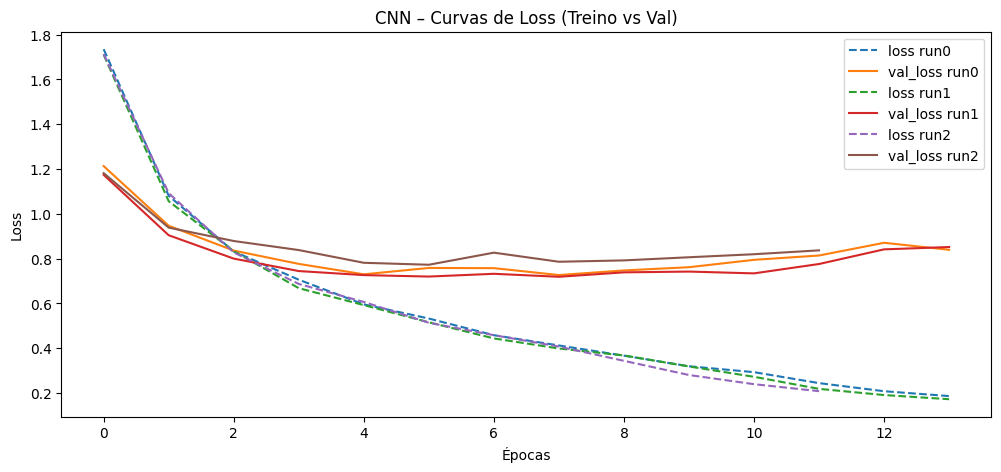

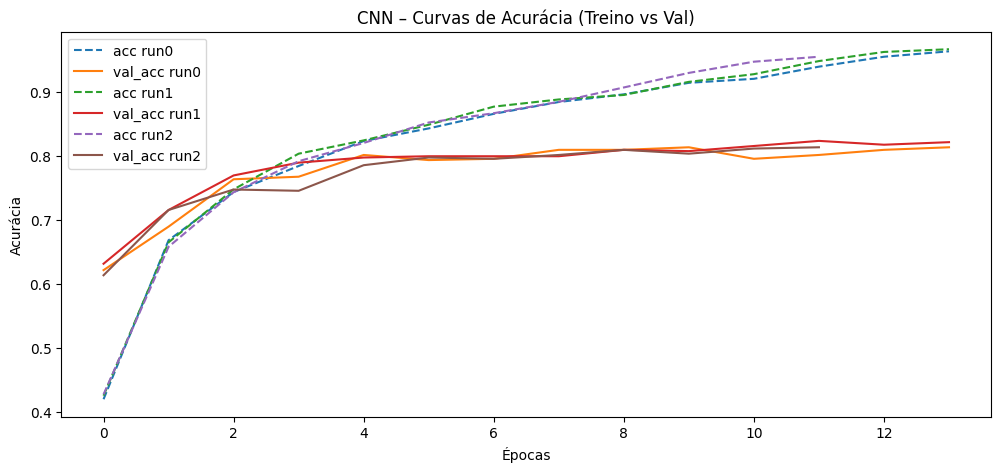

In [38]:
plt.figure(figsize=(12,5))
for i, r in enumerate(cnn_results):
    h = r["history"].history
    plt.plot(h["loss"], linestyle="--", label=f"loss run{i}")
    plt.plot(h["val_loss"], label=f"val_loss run{i}")
plt.title("CNN – Curvas de Loss (Treino vs Val)")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
for i, r in enumerate(cnn_results):
    h = r["history"].history
    plt.plot(h["accuracy"], linestyle="--", label=f"acc run{i}")
    plt.plot(h["val_accuracy"], label=f"val_acc run{i}")
plt.title("CNN – Curvas de Acurácia (Treino vs Val)")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.show()


In [ ]:
#Matriz de confusão da melhor execução

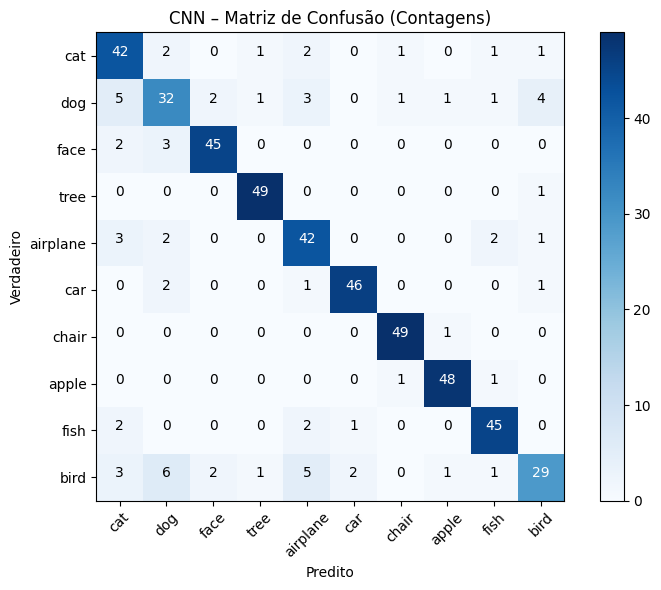

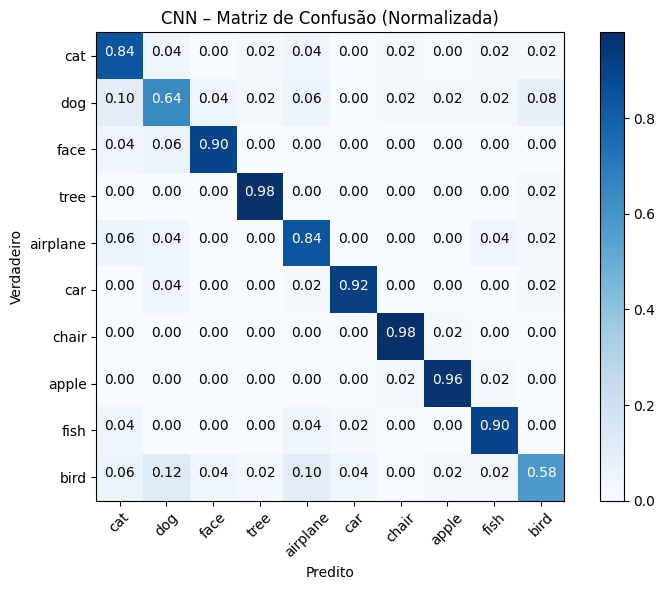

In [41]:
best_idx = np.argmax([r["f1"] for r in cnn_results])
best_preds = cnn_results[best_idx]["preds"]

cm = confusion_matrix(y_test, best_preds)

def plot_confusion_matrix(cm, classes, normalize=False, title="Matriz de Confusão"):
    plt.figure(figsize=(8,6))
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i,j], fmt),
                     ha="center",
                     color="white" if cm[i,j] > thresh else "black")

    plt.ylabel("Verdadeiro")
    plt.xlabel("Predito")
    plt.tight_layout()

plot_confusion_matrix(cm, CLASSES, normalize=False,
                      title="CNN – Matriz de Confusão (Contagens)")

plot_confusion_matrix(cm, CLASSES, normalize=True,
                      title="CNN – Matriz de Confusão (Normalizada)")
